In [1]:
#!pip install plotly
#!pip install ipywidgets
#!pip install bqplot ipyvuetify voila-vuetify

In [2]:
import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio
pio.renderers.default = 'notebook_connected'


In [4]:
import pandas as pd
df = pd.read_csv(
    'results/trade/liquidity.csv')



In [5]:
df.date = pd.to_datetime(df.date)
fig = px.line(df.set_index(['market', 'date']).sort_index().rolling(
    30, min_periods=1).mean().reset_index(), x='date', y='period', color='market')
fig.show()

In [8]:
import pandas as pd
df = pd.read_csv(
    'results/trade/lags_numeric_log_returns.csv').drop(columns=['Unnamed: 0'])
df.date = pd.to_datetime(df.date)
df = df.query("market1 == 'NL' or ((market1 < market2) and market2 != 'NL')")
df = df[df.lag.abs() < df.lag.abs().quantile(0.99)]
df['market'] = (df.market1 + ' & ' + df.market2)
fig = px.line(df.set_index(['market', 'date']).sort_index().rolling(
    30, min_periods=1).mean().reset_index(), x='date', y='lag', color='market')
fig.show()

df = df.set_index(['market1', 'market2', 'date']).sort_index()


165.0

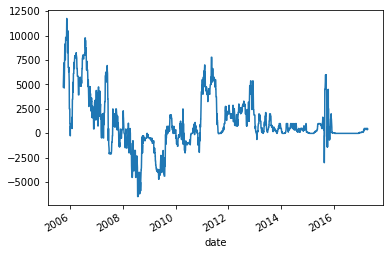

In [9]:
test = df.unstack(level=[0, 1]).lag.NL
test = (test.US - test.GB)
test = test[(test.abs() < test.abs().quantile(.95))]
test.rolling(30).median().plot()
test.median()

In [10]:
test = df.unstack(level=[0, 1]).lag.US
test = (test.NL - test.GB)
test = test[(test.abs() < test.abs().quantile(.95))]
test.rolling(30).median().plot()
test.median()


AttributeError: 'DataFrame' object has no attribute 'US'

In [11]:

def massage_df(frequency, window, markets):
    sub_df = df.loc[markets].sort_index()
    threshold = sub_df.lag.abs().quantile(0.975)
    massaged_df = (sub_df.query('lag.abs() < @threshold')
               .resample(frequency)
               .ffill()
               .rolling(window, min_periods=1)
               .mean()
               )
    return massaged_df.reset_index()


def concat_df(frequency, window, markets):
    massaged_df = None
    for m in markets:
        a = massage_df(frequency, window, m)
        a['markets'] = " & ".join(list(m))
        if massaged_df is None:
            massaged_df = a
        else:
            massaged_df = pd.concat((massaged_df, a), axis=0)
    return massaged_df

def plot_corr(frequency, window, markets):
    if not window or not frequency or not markets:
        return
   
    fig = px.line(concat_df(frequency, window, markets), x='date', y='lag',
                  title='Rolling Lag', color='markets')
    #fig.update_yaxes(range=(-1,1))
    fig.update_xaxes(
        rangeslider_visible=True,
        rangeselector=dict(
            buttons=list([
                dict(count=1, label="1m", step="month", stepmode="backward"),
                dict(count=6, label="6m", step="month", stepmode="backward"),
                dict(count=1, label="YTD", step="year", stepmode="todate"),
                dict(count=1, label="1y", step="year", stepmode="backward"),
                dict(step="all")
            ])
        )
    )
    fig.show()

#plot_corr('D', 10)

In [12]:
from ipywidgets import link,interactive, widgets, interact,Layout
config = {
    'layout': Layout(width='80%', height='80px'),
    'style': {'description_width': 'initial'}
}

# Interactive visualisation

<div class="alert alert-block alert-info">
    <b>Tip: use the widgets below to interact with the visualisation</b>
</div>


In [13]:

frequency_selector = widgets.ToggleButtons(
    options=[('daily','D'), ('weekly',  'W'), ('monthly','30d')],
    value='D',
    description='Sample frequency:',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltips=['Description of slow', 'Description of regular', 'Description of fast'],
    # icons=['check'] * 3
    **config,
)

markets_selector = widgets.ToggleButtons(
    options=[('all', [('NL', 'US'), ('GB', 'US',), ('NL', 'GB')]), ('US & NL', [('NL', 'US')]),
             ('US & GB',  [('GB', 'US')]), ('NL & GB', [('NL', 'GB')])],
    value=[('NL', 'US')],
    description='Markets:',
    disabled=False,
    button_style='',  # 'success', 'info', 'warning', 'danger' or ''
    tooltips=['Description of slow',
              'Description of regular', 'Description of fast'],
    # icons=['check'] * 3
    **config,
)


window_selector = widgets.IntSlider(
    value=10,
    min=1,
    max=30,
    step=1,
    description='Rolling window:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d',
    **config,
)

_ = interact(plot_corr, frequency=frequency_selector,
             window=window_selector, markets=markets_selector)


interactive(children=(ToggleButtons(description='Sample frequency:', layout=Layout(height='80px', width='80%')…